## Classification Model for Ligand H2 Production

This notebook transforms the regression model from `baseline_models.ipynb` into a 3-class classification model:
- **High**: > 10 µmol
- **Medium**: 1-10 µmol  
- **Low**: < 1 µmol

Using full filtered dataset (~181 samples, all Ni concentrations).

### 1. Initialize and Load Data

In [79]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Silence RDKit warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel('dataset.xlsx')
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (504, 46)


,Ligand Name,CAS,SMILES,Sample ID,Ni conc [mM],Well Row (0-indexed),Well Column (0-indexed),0,30,60,...,870,900,930,960,990,1020,1050,1080,1110,max h2 (umol)
0,"1,2-Benzenedithiol",17534-15-5,[S-]c1ccccc1[S-],L10,0.025,0,9,-0.195419,-0.055172,0.015477,...,0.159379,0.267298,0.232246,0.254219,0.268302,0.243670,0.248450,0.281460,0.228601,0.281460
1,triphenylphosphine,603-35-0,c1ccc(cc1)P(c2ccccc2)c3ccccc3,L11,0.025,0,10,-0.195419,-0.130641,-0.108585,...,-0.065574,0.058493,-0.004890,-0.033488,-0.052101,0.008465,-0.009168,0.054765,0.000038,0.058493
2,"1,2-bis(dicyclohexylphosphino)ethane",23743-26-2,C1CCC(CC1)P(CCP(C2CCCCC2)C3CCCCC3)C4CCCCC4,L12,0.025,0,11,-0.195419,-0.046476,0.017539,...,0.299408,0.390512,0.269879,0.281731,0.373348,0.326283,0.306061,0.315394,0.317026,0.390512
3,2-Mercaptonicotinic acid,38521-46-9,[O-]C(=O)c1cccnc1[S-],L2,0.025,0,1,-0.195419,-0.019767,0.265820,...,1.974575,2.286667,2.415076,2.699777,2.932207,3.241801,3.465248,3.753974,4.068596,4.068596
4,3-Aminopyridine-2(1H)-thione,38240-21-0,C1=CNC(=S)C(=C1)N,L3,0.025,0,2,-0.195419,-0.139284,0.037127,...,3.927982,4.563381,5.013864,5.565616,6.171127,6.913282,7.537440,8.266589,9.021096,9.021096


In [80]:
# Filter out ligands with low activity (keep >= 0.5 umol)
df_filtered = df[df['max h2 (umol)'] >= 0]
print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Kept {len(df_filtered)} samples out of {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
print(f"\nH2 production range: {df_filtered['max h2 (umol)'].min():.2f} - {df_filtered['max h2 (umol)'].max():.2f} µmol")
df_filtered.head()

Filtered dataset shape: (475, 46)
Kept 475 samples out of 504 (94.2%)

H2 production range: 0.00 - 21.08 µmol


,Ligand Name,CAS,SMILES,Sample ID,Ni conc [mM],Well Row (0-indexed),Well Column (0-indexed),0,30,60,...,870,900,930,960,990,1020,1050,1080,1110,max h2 (umol)
0,"1,2-Benzenedithiol",17534-15-5,[S-]c1ccccc1[S-],L10,0.025,0,9,-0.195419,-0.055172,0.015477,...,0.159379,0.267298,0.232246,0.254219,0.268302,0.243670,0.248450,0.281460,0.228601,0.281460
1,triphenylphosphine,603-35-0,c1ccc(cc1)P(c2ccccc2)c3ccccc3,L11,0.025,0,10,-0.195419,-0.130641,-0.108585,...,-0.065574,0.058493,-0.004890,-0.033488,-0.052101,0.008465,-0.009168,0.054765,0.000038,0.058493
2,"1,2-bis(dicyclohexylphosphino)ethane",23743-26-2,C1CCC(CC1)P(CCP(C2CCCCC2)C3CCCCC3)C4CCCCC4,L12,0.025,0,11,-0.195419,-0.046476,0.017539,...,0.299408,0.390512,0.269879,0.281731,0.373348,0.326283,0.306061,0.315394,0.317026,0.390512
3,2-Mercaptonicotinic acid,38521-46-9,[O-]C(=O)c1cccnc1[S-],L2,0.025,0,1,-0.195419,-0.019767,0.265820,...,1.974575,2.286667,2.415076,2.699777,2.932207,3.241801,3.465248,3.753974,4.068596,4.068596
4,3-Aminopyridine-2(1H)-thione,38240-21-0,C1=CNC(=S)C(=C1)N,L3,0.025,0,2,-0.195419,-0.139284,0.037127,...,3.927982,4.563381,5.013864,5.565616,6.171127,6.913282,7.537440,8.266589,9.021096,9.021096


In [81]:
# Generate molecular descriptors
from rdkit import Chem
from utils.utils import calculate_descriptors

smiles = df['SMILES'].unique().tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]
mol_names = df['Ligand Name'].unique().tolist()
mol_dict = {mol_names[i]: smiles[i] for i in range(len(smiles))}

# Calculate descriptors for ligand dataset
descriptor_data = []
for name, smiles_str in mol_dict.items():
    mol = Chem.MolFromSmiles(smiles_str)
    desc = calculate_descriptors(mol, name)
    descriptor_data.append(desc)

df_desc = pd.DataFrame(descriptor_data)
print(f"Molecular descriptors shape: {df_desc.shape}")
print(f"Number of features: {df_desc.shape[1] - 1}")  # -1 for 'Name' column

Molecular descriptors shape: (56, 218)
Number of features: 217


### 2. Create Classification Labels

In [82]:
# Merge molecular descriptors with experimental data
ml_data = df_filtered.set_index('Ligand Name').join(df_desc.set_index('Name'))
ml_data.reset_index(inplace=True)
ml_data.rename(columns={'index': 'Ligand Name'}, inplace=True)

print(f"ML dataset shape: {ml_data.shape}")
print(f"Samples: {len(ml_data)}")
ml_data.head()

ML dataset shape: (475, 263)
Samples: 475


,Ligand Name,CAS,SMILES,Sample ID,Ni conc [mM],Well Row (0-indexed),Well Column (0-indexed),0,30,60,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,"1,2-Benzenedithiol",17534-15-5,[S-]c1ccccc1[S-],L10,0.025,0,9,-0.195419,-0.055172,0.015477,...,0,0,0,0,0,0,0,0,0,0
1,triphenylphosphine,603-35-0,c1ccc(cc1)P(c2ccccc2)c3ccccc3,L11,0.025,0,10,-0.195419,-0.130641,-0.108585,...,0,0,0,0,0,0,0,0,0,0
2,"1,2-bis(dicyclohexylphosphino)ethane",23743-26-2,C1CCC(CC1)P(CCP(C2CCCCC2)C3CCCCC3)C4CCCCC4,L12,0.025,0,11,-0.195419,-0.046476,0.017539,...,0,0,0,0,0,0,0,0,0,0
3,2-Mercaptonicotinic acid,38521-46-9,[O-]C(=O)c1cccnc1[S-],L2,0.025,0,1,-0.195419,-0.019767,0.265820,...,0,0,0,0,0,0,0,0,0,0
4,3-Aminopyridine-2(1H)-thione,38240-21-0,C1=CNC(=S)C(=C1)N,L3,0.025,0,2,-0.195419,-0.139284,0.037127,...,0,0,0,0,0,0,0,0,0,0


Class Distribution:
h2_class
Low       294
High       94
Medium     87
Name: count, dtype: int64

Class proportions:
h2_class
Low       0.618947
High      0.197895
Medium    0.183158
Name: count, dtype: float64

Total samples: 475


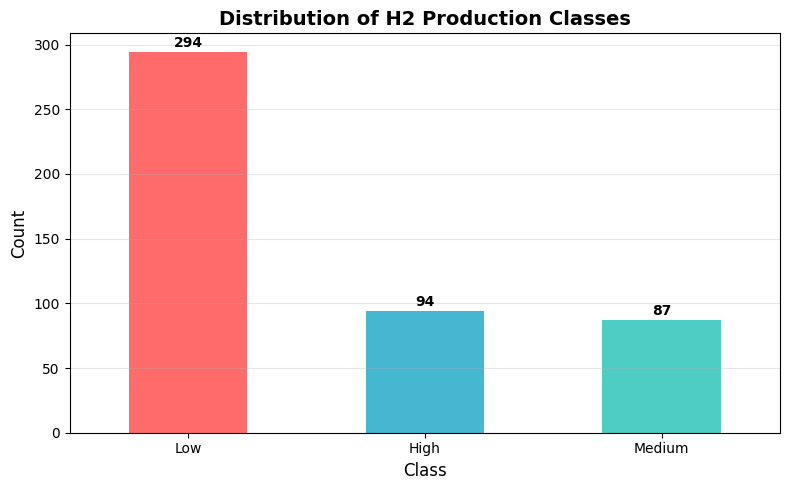

In [83]:
# Create classification labels based on specifications from classification.txt
def classify_h2_production(h2_value):
    if h2_value > 4:
        return 'High'
    elif h2_value >= 0.5:
        return 'Medium'
    else:
        return 'Low'

ml_data['h2_class'] = ml_data['max h2 (umol)'].apply(classify_h2_production)
ml_data['h2_class_encoded'] = ml_data['h2_class'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Visualize class distribution
class_counts = ml_data['h2_class'].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"\nClass proportions:")
print(class_counts / len(ml_data))
print(f"\nTotal samples: {len(ml_data)}")

# Create visualization
plt.figure(figsize=(8, 5))
colors = {'Low': '#FF6B6B', 'Medium': '#4ECDC4', 'High': '#45B7D1'}
class_counts.plot(kind='bar', color=[colors[cls] for cls in class_counts.index])
plt.title('Distribution of H2 Production Classes', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

### 3. Feature Preprocessing and Selection

In [84]:
# Use pre-selected features from baseline_models.ipynb
# These 10 features were selected via correlation analysis in the regression model
feature_cols_selected = ['BCUT2D_MRHI', 'FpDensityMorgan3', 'SlogP_VSA12',
                         'BCUT2D_MWHI', 'fr_Nhpyrrole', 'fr_unbrch_alkane',
                         'VSA_EState7', 'PEOE_VSA10', 'VSA_EState2', 'SlogP_VSA1']

X = ml_data[feature_cols_selected]
y = ml_data['h2_class_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nSelected features:")
for i, feat in enumerate(feature_cols_selected, 1):
    print(f"  {i}. {feat}")

Feature matrix shape: (475, 10)
Target vector shape: (475,)

Selected features:
  1. BCUT2D_MRHI
  2. FpDensityMorgan3
  3. SlogP_VSA12
  4. BCUT2D_MWHI
  5. fr_Nhpyrrole
  6. fr_unbrch_alkane
  7. VSA_EState7
  8. PEOE_VSA10
  9. VSA_EState2
  10. SlogP_VSA1


### 4. Model Definition and Training

In [85]:
# Train-test split with stratification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

print(f"Total samples: {len(X)}")
print(f"Train samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nFull dataset class distribution:")
print(pd.Series(y).value_counts().sort_index())
print(f"\nTrain class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"Test class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Total samples: 475
Train samples: 380 (80.0%)
Test samples: 95 (20.0%)

Full dataset class distribution:
h2_class_encoded
0    294
1     87
2     94
Name: count, dtype: int64

Train class distribution:
h2_class_encoded
0    235
1     70
2     75
Name: count, dtype: int64
Test class distribution:
h2_class_encoded
0    59
1    17
2    19
Name: count, dtype: int64


In [86]:
# Define classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        class_weight='balanced',
        random_state=21
    ),

    'SVC': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(
            kernel='poly',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=21
        ))
    ]),

    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=20,
        max_depth=3,
        learning_rate=0.1,
        random_state=21
    ),

    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            penalty='l2',
            C=1.0,
            class_weight='balanced',
            max_iter=1000,
            random_state=21
        ))
    ])
}

print(f"Defined {len(models)} classification models:")
for name in models.keys():
    print(f"  - {name}")

Defined 4 classification models:
  - Random Forest
  - SVC
  - Gradient Boosting
  - Logistic Regression


In [87]:
# Train models and evaluate
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import cross_val_score

results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training {name}...")
    print('='*80)

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 5-Fold Stratified Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                 scoring='balanced_accuracy', n_jobs=-1)

    # 10-Fold Stratified Cross-Validation
    cv_10fold_scores = cross_val_score(model, X_train, y_train, cv=10,
                                        scoring='balanced_accuracy', n_jobs=-1)

    # Calculate metrics
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Per-class F1 scores
    per_class_f1 = f1_score(y_test, y_test_pred, average=None)

    # Store results
    results[name] = {
        'model': model,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_balanced_acc': train_balanced_acc,
        'test_balanced_acc': test_balanced_acc,
        'test_macro_f1': test_macro_f1,
        'test_weighted_f1': test_weighted_f1,
        'per_class_f1': per_class_f1,
        'cv_5fold_balanced_acc_mean': cv_scores.mean(),
        'cv_5fold_balanced_acc_std': cv_scores.std(),
        'cv_10fold_balanced_acc_mean': cv_10fold_scores.mean(),
        'cv_10fold_balanced_acc_std': cv_10fold_scores.std(),
        'confusion_matrix': confusion_matrix(y_test, y_test_pred)
    }

    # Print results
    print(f"Train Balanced Accuracy: {train_balanced_acc:.3f}")
    print(f"Test Balanced Accuracy: {test_balanced_acc:.3f}")
    print(f"Test Macro F1: {test_macro_f1:.3f}")
    print(f"Test Weighted F1: {test_weighted_f1:.3f}")
    print(f"5-Fold CV Balanced Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"10-Fold CV Balanced Accuracy: {cv_10fold_scores.mean():.3f} ± {cv_10fold_scores.std():.3f}")
    print(f"\nPer-class F1 scores:")
    print(f"  Low (class 0): {per_class_f1[0]:.3f}")
    print(f"  Medium (class 1): {per_class_f1[1]:.3f}")
    print(f"  High (class 2): {per_class_f1[2]:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred,
                                target_names=['Low', 'Medium', 'High']))


Training Random Forest...
Train Balanced Accuracy: 0.715
Test Balanced Accuracy: 0.689
Test Macro F1: 0.655
Test Weighted F1: 0.700
5-Fold CV Balanced Accuracy: 0.638 ± 0.025
10-Fold CV Balanced Accuracy: 0.638 ± 0.066

Per-class F1 scores:
  Low (class 0): 0.752
  Medium (class 1): 0.486
  High (class 2): 0.727

Classification Report:
              precision    recall  f1-score   support

         Low       0.82      0.69      0.75        59
      Medium       0.45      0.53      0.49        17
        High       0.64      0.84      0.73        19

    accuracy                           0.69        95
   macro avg       0.64      0.69      0.66        95
weighted avg       0.72      0.69      0.70        95


Training SVC...
Train Balanced Accuracy: 0.604
Test Balanced Accuracy: 0.597
Test Macro F1: 0.520
Test Weighted F1: 0.518
5-Fold CV Balanced Accuracy: 0.581 ± 0.063
10-Fold CV Balanced Accuracy: 0.575 ± 0.076

Per-class F1 scores:
  Low (class 0): 0.511
  Medium (class 1): 0.438

### 5. Confusion Matrices

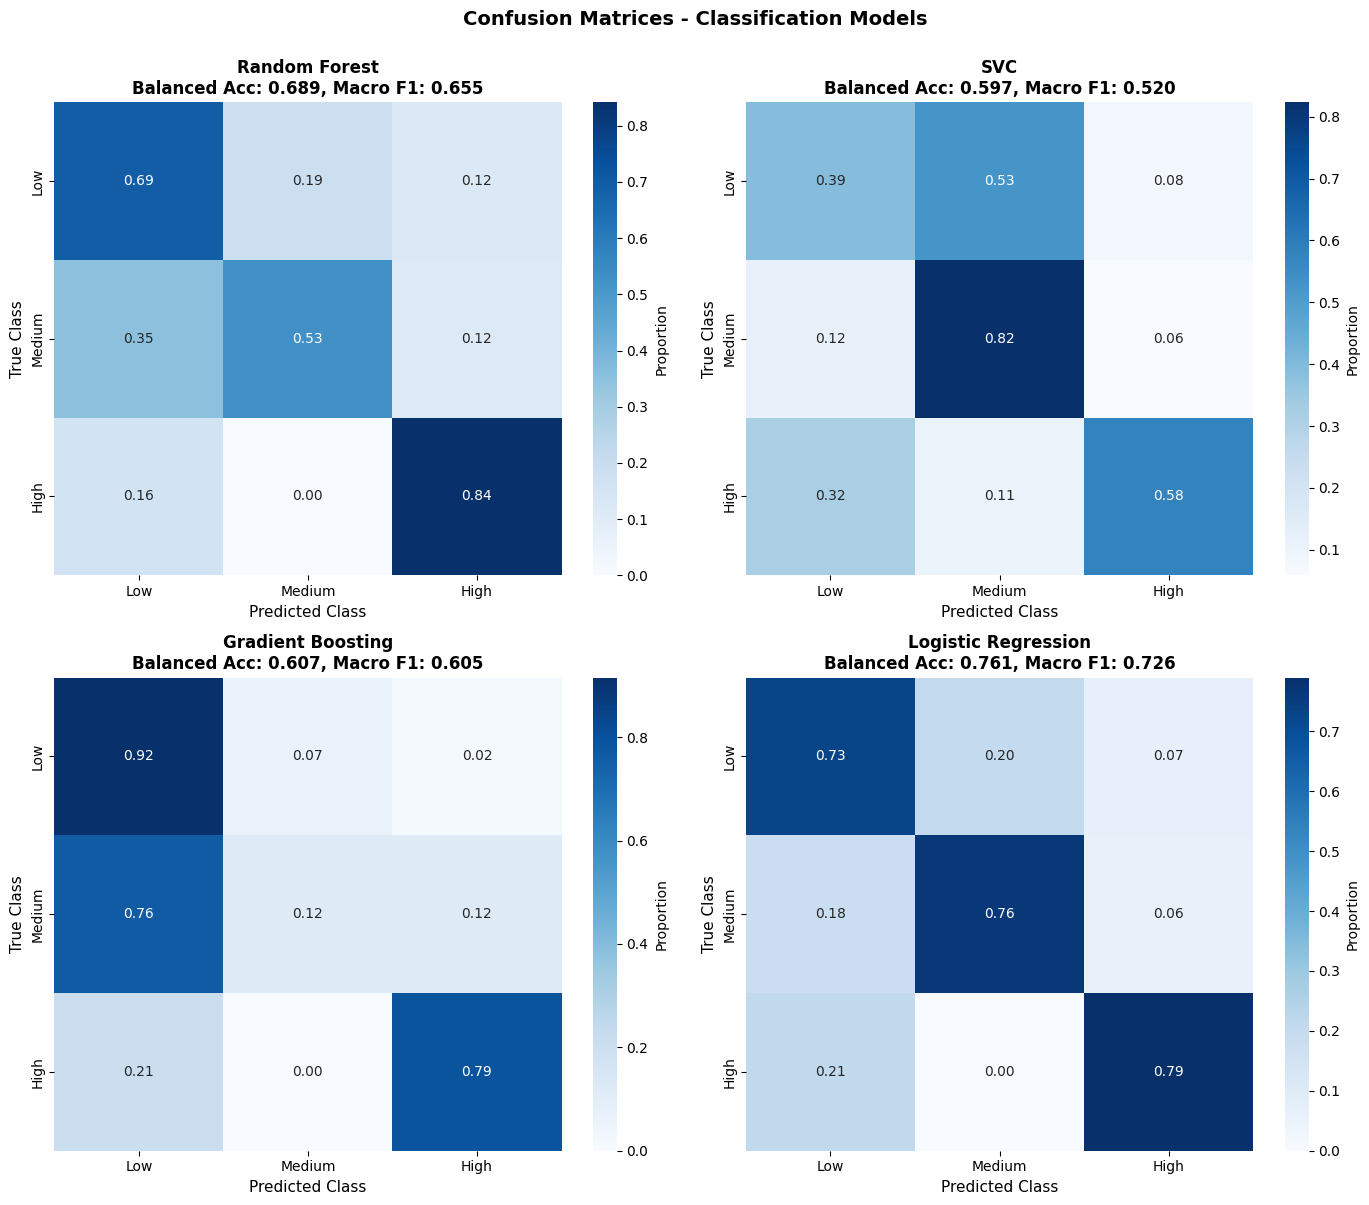

In [88]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

class_names = ['Low', 'Medium', 'High']

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Proportion'})

    axes[idx].set_title(f'{name}\nBalanced Acc: {result["test_balanced_acc"]:.3f}, '
                        f'Macro F1: {result["test_macro_f1"]:.3f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Class', fontsize=11)
    axes[idx].set_xlabel('Predicted Class', fontsize=11)

plt.suptitle('Confusion Matrices - Classification Models',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 6. Model Performance Comparison

In [89]:
# Create comparison DataFrame
comparison_data = {
    name: {
        'Train Balanced Acc': result['train_balanced_acc'],
        'Test Balanced Acc': result['test_balanced_acc'],
        'Test Macro F1': result['test_macro_f1'],
        '5-Fold CV Balanced Acc': result['cv_5fold_balanced_acc_mean'],
        '5-Fold CV Std': result['cv_5fold_balanced_acc_std'],
        '10-Fold CV Balanced Acc': result['cv_10fold_balanced_acc_mean'],
        '10-Fold CV Std': result['cv_10fold_balanced_acc_std'],
        'Low F1': result['per_class_f1'][0],
        'Medium F1': result['per_class_f1'][1],
        'High F1': result['per_class_f1'][2]
    }
    for name, result in results.items()
}

comparison_df = pd.DataFrame(comparison_data).T
print("\nModel Performance Comparison:")
print("="*100)
print(comparison_df.round(3))

# Identify best model
best_model_name = comparison_df['Test Balanced Acc'].idxmax()
print(f"\nBest model by Test Balanced Accuracy: {best_model_name}")
print(f"  Test Balanced Accuracy: {comparison_df.loc[best_model_name, 'Test Balanced Acc']:.3f}")
print(f"  Test Macro F1: {comparison_df.loc[best_model_name, 'Test Macro F1']:.3f}")


Model Performance Comparison:
                     Train Balanced Acc  Test Balanced Acc  Test Macro F1  \
Random Forest                     0.715              0.689          0.655   
SVC                               0.604              0.597          0.520   
Gradient Boosting                 0.669              0.607          0.605   
Logistic Regression               0.628              0.761          0.726   

                     5-Fold CV Balanced Acc  5-Fold CV Std  \
Random Forest                         0.638          0.025   
SVC                                   0.581          0.063   
Gradient Boosting                     0.622          0.045   
Logistic Regression                   0.586          0.042   

                     10-Fold CV Balanced Acc  10-Fold CV Std  Low F1  \
Random Forest                          0.638           0.066   0.752   
SVC                                    0.575           0.076   0.511   
Gradient Boosting                      0.624           0

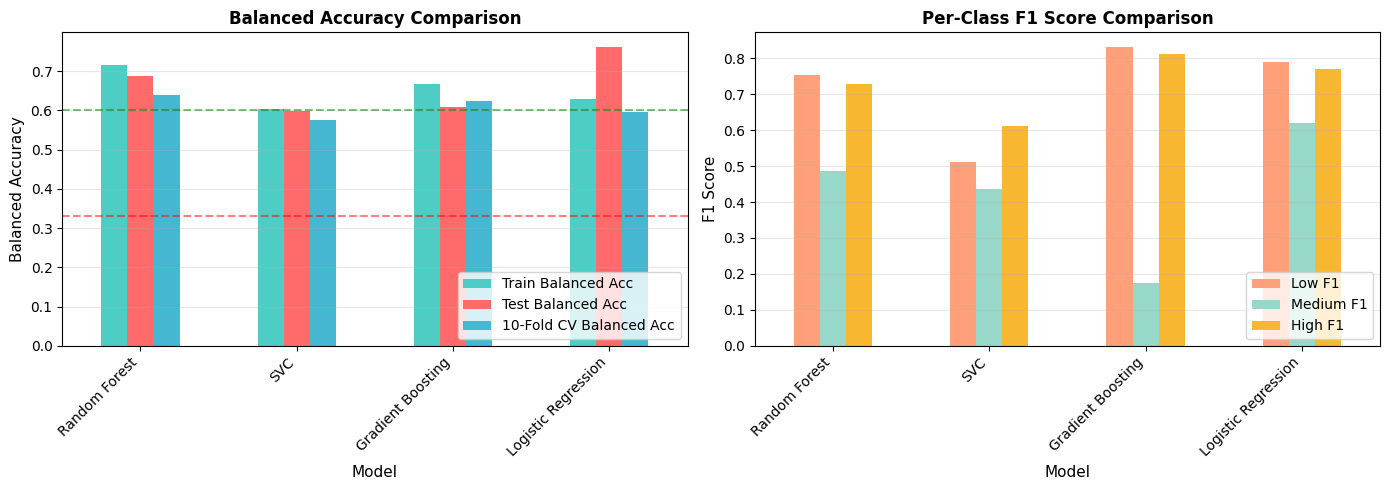

In [90]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Balanced Accuracy comparison
comparison_df[['Train Balanced Acc', 'Test Balanced Acc', '10-Fold CV Balanced Acc']].plot(
    kind='bar', ax=axes[0], color=['#4ECDC4', '#FF6B6B', '#45B7D1'])
axes[0].set_title('Balanced Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Balanced Accuracy', fontsize=11)
axes[0].set_xlabel('Model', fontsize=11)
axes[0].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0.33, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
axes[0].axhline(y=0.60, color='green', linestyle='--', alpha=0.5, label='Good Performance')

# Per-class F1 comparison
comparison_df[['Low F1', 'Medium F1', 'High F1']].plot(
    kind='bar', ax=axes[1], color=['#FFA07A', '#98D8C8', '#F7B731'])
axes[1].set_title('Per-Class F1 Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score', fontsize=11)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].legend(loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Feature Importance Analysis

In [91]:
# Extract feature importances
from sklearn.inspection import permutation_importance

feature_importances = {}

for name, result in results.items():
    model = result['model']
    print(f"Extracting feature importance for {name}...")

    # Handle pipeline models
    if isinstance(model, Pipeline):
        classifier = model.named_steps['classifier']
        if hasattr(classifier, 'coef_'):
            # Logistic Regression coefficients (average across classes)
            importances = np.abs(classifier.coef_).mean(axis=0)
        else:
            # Use permutation importance for SVC
            perm_importance = permutation_importance(
                model, X_test, y_test, n_repeats=10,
                random_state=21, scoring='balanced_accuracy'
            )
            importances = perm_importance.importances_mean
    elif hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = model.feature_importances_
    else:
        # Fallback to permutation importance
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10,
            random_state=21, scoring='balanced_accuracy'
        )
        importances = perm_importance.importances_mean

    feature_importances[name] = pd.DataFrame({
        'feature': feature_cols_selected,
        'importance': importances
    }).sort_values('importance', ascending=False)

print("Feature importance extraction complete.")

Extracting feature importance for Random Forest...
Extracting feature importance for SVC...
Extracting feature importance for Gradient Boosting...
Extracting feature importance for Logistic Regression...
Feature importance extraction complete.


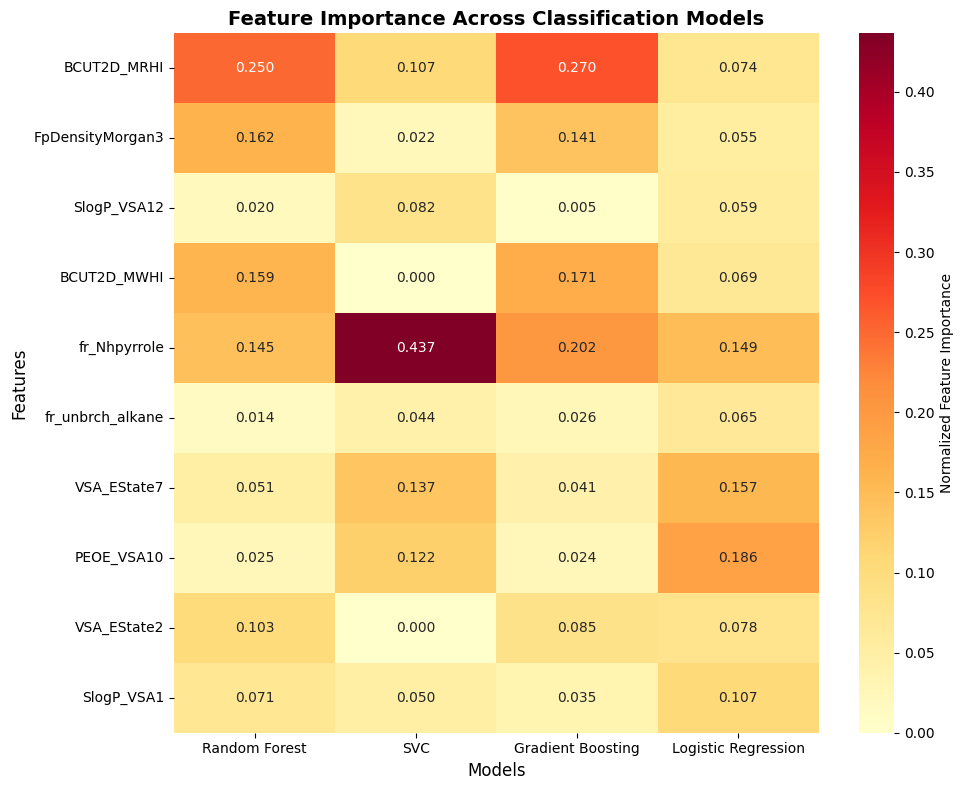


Top 5 Most Important Features by Model:

Random Forest:
         feature  importance
     BCUT2D_MRHI    0.250113
FpDensityMorgan3    0.162279
     BCUT2D_MWHI    0.159471
    fr_Nhpyrrole    0.144519
     VSA_EState2    0.102587

SVC:
     feature  importance
fr_Nhpyrrole    0.145750
 VSA_EState7    0.045721
  PEOE_VSA10    0.040750
 BCUT2D_MRHI    0.035686
 SlogP_VSA12    0.027442

Gradient Boosting:
         feature  importance
     BCUT2D_MRHI    0.269683
    fr_Nhpyrrole    0.201536
     BCUT2D_MWHI    0.171358
FpDensityMorgan3    0.140950
     VSA_EState2    0.084724

Logistic Regression:
     feature  importance
  PEOE_VSA10    0.503781
 VSA_EState7    0.424186
fr_Nhpyrrole    0.403522
  SlogP_VSA1    0.289401
 VSA_EState2    0.212245


In [92]:
# Create feature importance heatmap
importance_matrix = pd.DataFrame(index=feature_cols_selected)

for model_name, importance_df in feature_importances.items():
    importances = importance_df.set_index('feature')['importance']
    importances = np.maximum(importances, 0)
    if importances.sum() > 0:
        normalized_importances = importances / importances.sum()
    else:
        normalized_importances = importances * 0
    importance_matrix[model_name] = normalized_importances.reindex(
        feature_cols_selected, fill_value=0
    )

plt.figure(figsize=(10, 8))
sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Normalized Feature Importance'})
plt.title('Feature Importance Across Classification Models',
          fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.tight_layout()
plt.show()

# Print top 5 features for each model
print("\nTop 5 Most Important Features by Model:")
print("="*80)
for model_name, importance_df in feature_importances.items():
    print(f"\n{model_name}:")
    print(importance_df.head(5).to_string(index=False))

### 8. Summary and Key Findings

In [93]:
# Generate comprehensive summary
print("="*80)
print("CLASSIFICATION MODEL SUMMARY")
print("="*80)

print(f"\nDataset Information:")
print(f"  Total samples: {len(ml_data)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Number of features: {len(feature_cols_selected)}")

print(f"\nClass Distribution:")
for class_label in ['Low', 'Medium', 'High']:
    count = (ml_data['h2_class'] == class_label).sum()
    pct = count / len(ml_data) * 100
    print(f"  {class_label}: {count} samples ({pct:.1f}%)")

print(f"\nModel Performance (sorted by Test Balanced Accuracy):")
sorted_results = comparison_df.sort_values('Test Balanced Acc', ascending=False)
for idx, (model_name, row) in enumerate(sorted_results.iterrows(), 1):
    print(f"\n  {idx}. {model_name}")
    print(f"     Test Balanced Accuracy: {row['Test Balanced Acc']:.3f}")
    print(f"     Test Macro F1: {row['Test Macro F1']:.3f}")
    print(f"     10-Fold CV: {row['10-Fold CV Balanced Acc']:.3f} ± {row['10-Fold CV Std']:.3f}")
    print(f"     Per-class F1: Low={row['Low F1']:.3f}, Medium={row['Medium F1']:.3f}, High={row['High F1']:.3f}")

print(f"\nSuccess Criteria Assessment:")
print(f"  ✓ Minimum (Balanced Acc > 0.50): {'PASSED' if sorted_results.iloc[0]['Test Balanced Acc'] > 0.50 else 'FAILED'}")
print(f"  ✓ Good (Balanced Acc > 0.60): {'PASSED' if sorted_results.iloc[0]['Test Balanced Acc'] > 0.60 else 'NOT MET'}")
print(f"  ✓ Excellent (Balanced Acc > 0.70): {'PASSED' if sorted_results.iloc[0]['Test Balanced Acc'] > 0.70 else 'NOT MET'}")

print(f"\nMost Important Features (from best model - {sorted_results.index[0]}):")
best_model_features = feature_importances[sorted_results.index[0]].head(5)
for idx, row in best_model_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print("\n" + "="*80)

CLASSIFICATION MODEL SUMMARY

Dataset Information:
  Total samples: 475
  Training samples: 380
  Test samples: 95
  Number of features: 10

Class Distribution:
  Low: 294 samples (61.9%)
  Medium: 87 samples (18.3%)
  High: 94 samples (19.8%)

Model Performance (sorted by Test Balanced Accuracy):

  1. Logistic Regression
     Test Balanced Accuracy: 0.761
     Test Macro F1: 0.726
     10-Fold CV: 0.595 ± 0.080
     Per-class F1: Low=0.789, Medium=0.619, High=0.769

  2. Random Forest
     Test Balanced Accuracy: 0.689
     Test Macro F1: 0.655
     10-Fold CV: 0.638 ± 0.066
     Per-class F1: Low=0.752, Medium=0.486, High=0.727

  3. Gradient Boosting
     Test Balanced Accuracy: 0.607
     Test Macro F1: 0.605
     10-Fold CV: 0.624 ± 0.079
     Per-class F1: Low=0.831, Medium=0.174, High=0.811

  4. SVC
     Test Balanced Accuracy: 0.597
     Test Macro F1: 0.520
     10-Fold CV: 0.575 ± 0.076
     Per-class F1: Low=0.511, Medium=0.438, High=0.611

Success Criteria Assessment:
  ✓